In [11]:
import sys; print(sys.version)
import os
import glob
import subprocess
import multiprocessing
import functools
from collections import OrderedDict
import timeit

import numpy as np; print('numpy', np.__version__)
import matplotlib as mpl; print('matplotlib', mpl.__version__)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd; print('pandas',pd.__version__)
import allel; print('allel', allel.__version__)
import zarr; print('zarr', zarr.__version__)

sys.path.append('utils/')
import allel_helpers; print('allel_helpers', allel_helpers.__version__)

from IPython.display import display, HTML

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
numpy 1.16.2
matplotlib 3.0.3
pandas 0.24.2
allel 1.2.1
zarr 2.3.2
allel_helpers 0.2.0


In [12]:
# Use interactive 'notebook' matplotlib figures
%matplotlib notebook

## Settings/Constants

In [13]:
META_FN = 'example_data/example_STP_meta.csv'
INFN_ZARR = 'example_data/example_STP.vcf.gz.zarr'

SAVE = False # save results as files

CHROMS = ['2R','2L','3R','3L','X']
ADD_REFERENCE = True

GROUP_COL = 'locality'
GROUP_MAX_MISSING_PROPORTION = None

FILTER_SNP = True
FILTER_BIALLELIC = True
FILTER_SINGLETON = True # also filters biallelic
MIN_FMTDP = 6
MAX_MISSING_PROPORTION = 0.10 # applied for set of all samples in meta

## Metadata processing
The metadata gives the properties (eg. location) for each sample we use when plotting.

In [14]:
meta_in = pd.read_csv(META_FN, index_col=0, comment='#', usecols=[0,2,3])

# add a new label column
meta_in['label'] = meta_in['locality'].map(str)+', '+meta_in['Country']

In [15]:
meta_in

,locality,Country,label
sample ID,,,
6617_P,Principe,STP,"Principe, STP"
6917_K,Principe,STP,"Principe, STP"
0117_A,Alto Doro,STP,"Alto Doro, STP"
0117_J,Alto Doro,STP,"Alto Doro, STP"
0117_N,Alto Doro,STP,"Alto Doro, STP"
10217_H,Alto Doro,STP,"Alto Doro, STP"
10217_I,Alto Doro,STP,"Alto Doro, STP"
10617_L,Alto Doro,STP,"Alto Doro, STP"
10617_N,Alto Doro,STP,"Alto Doro, STP"


## Open the callset (variant data)
The `callset` is actually an object which will read data we need from a `zarr` archive.  
The archive was created from a vcf file using the `vcf2zarr.py` script, and is much faster to access.

We also read `callset_all_sample_ids` (all the sample IDs) from the callset.

In [16]:
callset = zarr.open_group(INFN_ZARR, mode='r')
callset_all_sample_ids = list(list(callset.values())[0]['samples'])

### Actually loading the callset data into `GenotypeArray`s

This function takes the metadata as an input and returns copy
with an additional `callset_idx` (the index of the sample in the callset) column added.

In [17]:
g_dict = OrderedDict()
pos_dict = OrderedDict()
meta = None
for ch in CHROMS:
    print("Chrom:", ch)
    g_dict[ch],pos_dict[ch],meta_out = allel_helpers.LoadRegion(
                callset, meta_in, ch,
                min_FMTDP=MIN_FMTDP,
                filter_snp=FILTER_SNP,
                filter_biallelic=FILTER_BIALLELIC,
                max_missing_proportion=MAX_MISSING_PROPORTION,
                group_col=GROUP_COL,
                group_max_missing_proportion=GROUP_MAX_MISSING_PROPORTION)

    if meta is None:
        meta = meta_out
    else:
        # ensure meta hasn't changed (it should be the same for all chroms)
        assert meta.equals(meta_out)
        
# make a copy of meta so we don't have to worry about reusing the name
g_dict_meta = meta.copy(deep=True)

Chrom: 2R
Region: 2R -> ('2R', 1, None)
total number of loci = 13451
538217 genotype calls of 1035727 (51.97%) fail FMT:DP filter
= 10824 passing previous filters & SNP
= 7320 passing previous filters & biallelic
max missing proportion 0.1 of 77 is 7
max missing passing loci = 2722 (20.24%)
= 2706 passing previous filters & max_missing
Passing all all filters 2706 of 13451 (20.12%)
Chrom: 2L
Region: 2L -> ('2L', 1, None)
total number of loci = 2243
72767 genotype calls of 172711 (42.13%) fail FMT:DP filter
= 2019 passing previous filters & SNP
= 1661 passing previous filters & biallelic
max missing proportion 0.1 of 77 is 7
max missing passing loci = 589 (26.26%)
= 585 passing previous filters & max_missing
Passing all all filters 585 of 2243 (26.08%)
Chrom: 3R
Region: 3R -> ('3R', 1, None)
total number of loci = 13844
472887 genotype calls of 1065988 (44.36%) fail FMT:DP filter
= 12076 passing previous filters & SNP
= 8568 passing previous filters & biallelic
max missing proportion 0.

In [18]:
print("Total loci passing all filters", sum([_.shape[0] for _ in g_dict.values()]))

Total loci passing all filters 8036


# PCA

In [9]:
# start with clean version of the genotype array and meta based on g_dict
# combine GenotypeArrays into a single one
g = g_dict[list(g_dict.keys())[0]].concatenate([g_dict[ch] for ch in list(g_dict.keys())[1:]])
# copy the meta
meta = g_dict_meta.copy(deep=True)

## Add reference as a virtual sample

In [10]:
if ADD_REFERENCE:
    g = g.concatenate(allel.GenotypeArray(np.zeros([g.shape[0],1,2],dtype=np.int8),g), axis=1)
    meta = pd.concat([meta, 
                      pd.DataFrame({GROUP_COL:'Reference',
                                    'idx':g.shape[1]-1}, 
                                    index=['Reference'])], 
                      sort=True)

## Filter out singletons (not informative for PCA) and any non-biallelic we missed

In [11]:
%%time
if FILTER_SINGLETON:
    # will need to re-filter for biallelic non-singleton
    # based on http://alimanfoo.github.io/2015/09/28/fast-pca.html
    ac = g.count_alleles()
    loc_biallelic_nosgl = (ac.max_allele() == 1) & (ac[:,:2].min(axis=1) > 1)
    print("additional biallelic + non-singleton filter removed:",ac.shape[0]-np.count_nonzero(loc_biallelic_nosgl))
    g = g.compress(loc_biallelic_nosgl, axis=0)

additional biallelic + non-singleton filter removed: 1220852
CPU times: user 3.02 s, sys: 584 ms, total: 3.6 s
Wall time: 3.58 s


In [12]:
print("Final filtered number of loci", g.shape[0])

Final filtered number of loci 3867530


## Make n_alt (alt allele count array) used in actual PCA computations below

In [13]:
%%time
# transform genotype data into a 2-D matrix where each cell has the num of non-ref alleles per call
gn = g.to_n_alt()

CPU times: user 6.21 s, sys: 484 ms, total: 6.69 s
Wall time: 6.67 s


### biallelic loci where the ref isn't observed are counted as monomorphic by to_n_alt...
we can fix by mapping those alleles so idx 0 is the first alt

!! *Don't need to do this if ref is included as virtual sample*

In [14]:
if not ADD_REFERENCE: # @TCC Don't need if ref is virtual sample
    gfr = g
    flt = np.nonzero(np.sum(gn,axis=1) == 2*gn.shape[1])[0]
    print("number of biallelic but unboserved ref loci: "+str(len(flt)))

    gn2 = gn.copy()

    # Remap those problematic alleles
    if len(flt) > 0:
        gn2[flt] = gfr[flt].map_alleles(np.repeat([[2,0,1]],gfr[flt].shape[0],axis=0)).to_n_alt()

    # @TCC HACK!!!
    # fix loci where allele idxs aren't 0,1,2 (gn2 will have them set to all 0 now)
    # @TCC NEED TO MAKE THIS MORE GENERAL
    flt = np.nonzero(np.sum(gn2,axis=1) == 0)[0]
    # Remap those problematic alleles
    if len(flt) > 0:
        gn2[flt] = gfr[flt].map_alleles(np.repeat([[3,1,0]],gfr[flt].shape[0],axis=0)).to_n_alt()
else:
    gn2 = gn

In [15]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population, pop_colors):
    #sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in POPULATIONS:
        flt = (sample_population == pop)
#        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colors[pop],
#                label="{:s} ({:d})".format(pop,counts[pop]),
        ax.plot(-x[flt], y[flt], marker=pop_colors[pop][2], linestyle=' ', color=pop_colors[pop][1],
#                 label="{:s}".format(pop),
                label=pop_colors[pop][0],
                markersize=8, mec='k', mew=.5, clip_on=False)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title, sample_population=None, pop_colors=None):
    if sample_population is None:
        sample_population = df_samples.population.values
    # plot coords for PCs 1 vs 2, 3 vs 4
    gs = gridspec.GridSpec(2,3, height_ratios=(1,.75))
    fig = plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,:])
    ax4 = plt.subplot(gs[0,2])

    plot_pca_coords(coords, model, 1, 0, ax1, sample_population, pop_colors)
#     ax1.invert_yaxis()  
#     ax1.invert_xaxis()  
    
    plot_pca_coords(coords, model, 2, 3, ax2, sample_population, pop_colors)
#     ax2.invert_yaxis()  
#     ax2.invert_xaxis()  
        
    plot_pca_coords(coords, model, 4, 5, ax4, sample_population, pop_colors)
#     ax4.invert_yaxis()  
#     ax4.invert_xaxis()    
    
#     ax1.xaxis.set_ticks(np.arange(start, end, stepsize))
    ax3.axis('off')
    handles, labels = ax1.get_legend_handles_labels()
    leg = ax3.legend(handles, labels,
                     numpoints=1,
                     fontsize=10,
                     ncol=4, mode="expand",
                     loc='upper center',
#                      fancybox=True,
                     frameon=False,
                     borderaxespad=0.)
    fig.suptitle(title, y=.99)
    fig.tight_layout(rect=(0,0,1,.975))
    
    return fig

In [16]:
%%time
coords, model = allel.pca(gn2, n_components=10, scaler=None)#'patterson')

CPU times: user 8min 14s, sys: 5min 41s, total: 13min 56s
Wall time: 1min 32s


In [17]:
# POPULATIONS = set(meta[GROUP_COL].values)
# display(POPULATIONS)
# display(len(POPULATIONS))

# # automatic population colours
# cmap = mpl.cm.tab20

# POP_COLOURS = {}
# for i,pop in enumerate(POPULATIONS):
#     POP_COLOURS[pop] = [cmap(i), 'o']

In [18]:
cmap = mpl.cm.tab20

# set colours by hand
POP_COLOURS = OrderedDict([
    ['Reference', ['Reference', 'black', 'x']],
    
    ['Sao Tome', ['Sao Tome, STP', cmap(0), 'o']],
    ['Alto Doro', ['Alto Doro, STP', cmap(18), 'o']],
    ['Principe', ['Principe, STP', cmap(8), 'o']],
    
    ['Luanda', ['Luanda, Angola', cmap(1), 'v']],
    
    ['Bioko', ['Bioko, Equatorial Guinea', cmap(10), '>']],
    ['Gabon', ['Gabon', cmap(3), '>']],
    ['Tiko', ['Tiko, Cameroon', cmap(12), '>']],

    ['Abomey', ['Abomey, Benin', cmap(2), '<']],
    ['Cove', ['Cove, Benin', cmap(4), '<']],
    ['Tori', ['Tori, Benin', cmap(11), '<']],

    ['Selinkenyi', ['Selinkenyi, Mali', cmap(5), '^']],
])

POPULATIONS = list(POP_COLOURS.keys())

<IPython.core.display.Javascript object>


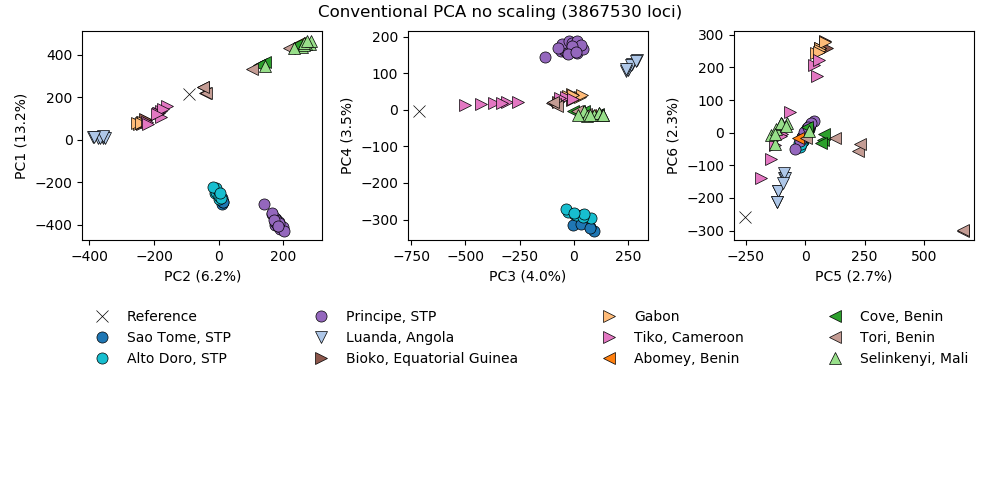

In [19]:
fig = fig_pca(coords, model, 
        'Conventional PCA no scaling ('+str(gn.shape[0])+' loci)', 
        meta[GROUP_COL].values,
       pop_colors=POP_COLOURS)
if SAVE:
    plt.savefig('PCA_MINFMTDP-{}_MAX_MISSING_PROPORTION-{}.svg'.format(
        MIN_FMTDP, MAX_MISSING_PROPORTION))

<IPython.core.display.Javascript object>


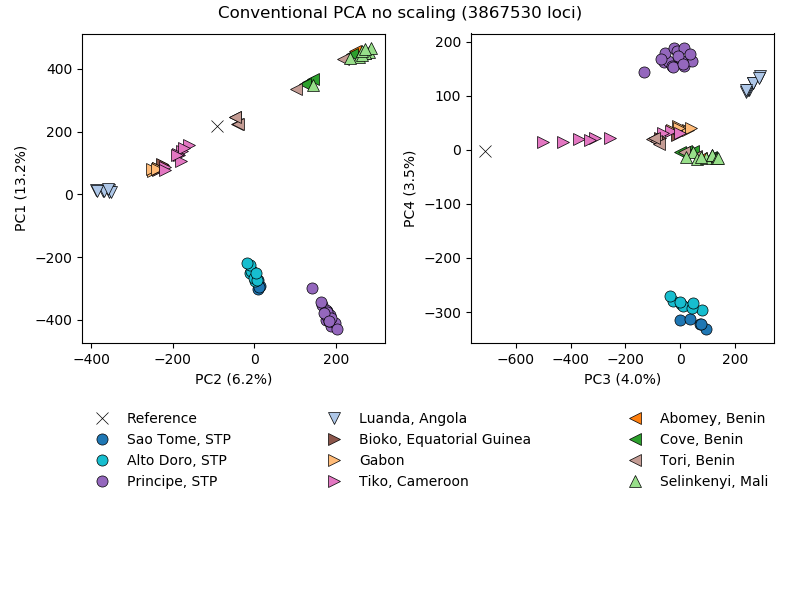

In [20]:
def fig_pca2(coords, model, title, sample_population=None, pop_colors=None):
    if sample_population is None:
        sample_population = df_samples.population.values
    # plot coords for PCs 1 vs 2, 3 vs 4
    gs = gridspec.GridSpec(2,2, height_ratios=(1.5,.75))
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,:])
#     ax4 = plt.subplot(gs[0,2])

    plot_pca_coords(coords, model, 1, 0, ax1, sample_population, pop_colors)
#     ax1.invert_yaxis()  
#     ax1.invert_xaxis()  
    
    plot_pca_coords(coords, model, 2, 3, ax2, sample_population, pop_colors)
#     ax2.invert_yaxis()  
#     ax2.invert_xaxis()  
        
#     plot_pca_coords(coords, model, 4, 5, ax4, sample_population, pop_colors)
# #     ax4.invert_yaxis()  
# #     ax4.invert_xaxis()    
    
#     ax1.xaxis.set_ticks(np.arange(start, end, stepsize))
    ax3.axis('off')
    handles, labels = ax1.get_legend_handles_labels()
    leg = ax3.legend(handles, labels,
                     numpoints=1,
                     fontsize=10,
                     ncol=3, mode="expand",
                     loc='upper center',
#                      fancybox=True,
                     frameon=False,
                     borderaxespad=0.)
    fig.suptitle(title, y=.99)
    fig.tight_layout(rect=(0,0,1,.975))
    return fig

fig = fig_pca2(coords, model, 
        'Conventional PCA no scaling ('+str(gn.shape[0])+' loci)', 
        meta[GROUP_COL].values,
       pop_colors=POP_COLOURS)
plt.savefig('PCA2_MINFMTDP-{}_MAX_MISSING_PROPORTION-{}.svg'.format(MIN_FMTDP, MAX_MISSING_PROPORTION))

In [21]:
# save the meta and pca coordinates for each sample to a csv file
out = pd.concat([meta, pd.DataFrame(coords, index=meta.index)], axis=1)
if SAVE:
    out.to_csv('pca_coords.csv')

# $F_{ST}$

In [22]:
# start with clean version of the genotype array and meta based on g_dict
# combine GenotypeArrays into a single one
g = g_dict[list(g_dict.keys())[0]].concatenate([g_dict[ch] for ch in list(g_dict.keys())[1:]])
# copy the meta
meta = g_dict_meta.copy(deep=True)

In [25]:
# assert meta == meta.sort_values('callset_idx')

In [26]:
meta

,locality,Country,label,callset_idx,idx
sample ID,,,,,
6617_P,Principe,STP,"Principe, STP",8,0
6917_K,Principe,STP,"Principe, STP",64,1
0117_A,Alto Doro,STP,"Alto Doro, STP",46,2
0117_J,Alto Doro,STP,"Alto Doro, STP",70,3
0117_N,Alto Doro,STP,"Alto Doro, STP",60,4
10217_H,Alto Doro,STP,"Alto Doro, STP",55,5
10217_I,Alto Doro,STP,"Alto Doro, STP",52,6
10617_L,Alto Doro,STP,"Alto Doro, STP",38,7
10617_N,Alto Doro,STP,"Alto Doro, STP",57,8


In [32]:
## By sample
meta['sample'] = meta.index
group_col = 'sample'
if 'Reference' in meta: meta.drop('Reference', inplace=True)

# all_groups = meta[group_col].unique()
# all_groups = np.delete(all_groups, np.argwhere(all_groups=='Reference')) # remove Reference group if there

all_groups = meta['sample'].unique()

hfst_df = pd.DataFrame(index=all_groups, columns=all_groups)

# meta must be sorted by callset_idx
# meta.sort_values('callset_idx', inplace=True)

for i1 in range(len(all_groups)):
    grp1 = all_groups[i1]
    g1 = g[:,meta[meta[group_col]==grp1].idx]
    ac1 = g1.count_alleles()

    for i2 in range(i1):
        grp2 = all_groups[i2]
        print(group_col, ':', grp1, 'v', grp2)

        g2 = g[:,meta[meta[group_col]==grp2].idx]
        ac2 = g2.count_alleles()
        
        # @TCC -- TODO Should probably use allel.average_hudson_fst instead
        num,den = allel.hudson_fst(ac1, ac2, fill=0)
        hfst = np.sum(num)/np.sum(den)
        hfst_df.loc[grp1,grp2] = hfst
        
        # fill in symmetric values
        hfst_df.loc[grp2,grp1] = hfst

#         if i2 > 1: break  # @TCC testing shortcut
#     if i1 > 1: break  # @TCC testing shortcut
hfst_df

sample : 6917_K v 6617_P


/share/lanzarolab/opt/conda/vgl/lib/python3.6/site-packages/allel/stats/diversity.py:102: RuntimeWarning: divide by zero encountered in true_divide
  mpd = np.where(n_pairs > 0, n_diff / n_pairs, fill)
/share/lanzarolab/opt/conda/vgl/lib/python3.6/site-packages/allel/stats/diversity.py:201: RuntimeWarning: divide by zero encountered in true_divide
  mpd = np.where(n_pairs > 0, n_diff / n_pairs, fill)


sample : 0117_A v 6617_P
sample : 0117_A v 6917_K
sample : 0117_J v 6617_P
sample : 0117_J v 6917_K
sample : 0117_J v 0117_A
sample : 0117_N v 6617_P
sample : 0117_N v 6917_K
sample : 0117_N v 0117_A
sample : 0117_N v 0117_J
sample : 10217_H v 6617_P
sample : 10217_H v 6917_K
sample : 10217_H v 0117_A
sample : 10217_H v 0117_J
sample : 10217_H v 0117_N
sample : 10217_I v 6617_P
sample : 10217_I v 6917_K
sample : 10217_I v 0117_A
sample : 10217_I v 0117_J
sample : 10217_I v 0117_N
sample : 10217_I v 10217_H
sample : 10617_L v 6617_P
sample : 10617_L v 6917_K
sample : 10617_L v 0117_A
sample : 10617_L v 0117_J
sample : 10617_L v 0117_N
sample : 10617_L v 10217_H
sample : 10617_L v 10217_I
sample : 10617_N v 6617_P
sample : 10617_N v 6917_K
sample : 10617_N v 0117_A
sample : 10617_N v 0117_J
sample : 10617_N v 0117_N
sample : 10617_N v 10217_H
sample : 10617_N v 10217_I
sample : 10617_N v 10617_L
sample : 0117_D v 6617_P
sample : 0117_D v 6917_K
sample : 0117_D v 0117_A
sample : 0117_D v 

sample : 03TIKO0059 v 0117_N
sample : 03TIKO0059 v 10217_H
sample : 03TIKO0059 v 10217_I
sample : 03TIKO0059 v 10617_L
sample : 03TIKO0059 v 10617_N
sample : 03TIKO0059 v 0117_D
sample : 03TIKO0059 v 10217_L
sample : 03TIKO0059 v 6217_G
sample : 03TIKO0059 v 6317_R
sample : 03TIKO0059 v 6317_W
sample : 03TIKO0059 v 6417_K
sample : 03TIKO0059 v 6617_B
sample : 03TIKO0059 v 8017_D
sample : 03TIKO0059 v 6017_C
sample : 03TIKO0059 v 6317_Z
sample : 03TIKO0059 v 02BIOK020
sample : 03TIKO0059 v 02BIOK021
sample : 03TIKO0059 v 02BIOK028
sample : 03TIKO0059 v 03TIKO0027
sample : 03TIKO0059 v 03TIKO0032
sample : 03TIKO0059 v 03TIKO0052
sample : 11TIKO403 v 6617_P
sample : 11TIKO403 v 6917_K
sample : 11TIKO403 v 0117_A
sample : 11TIKO403 v 0117_J
sample : 11TIKO403 v 0117_N
sample : 11TIKO403 v 10217_H
sample : 11TIKO403 v 10217_I
sample : 11TIKO403 v 10617_L
sample : 11TIKO403 v 10617_N
sample : 11TIKO403 v 0117_D
sample : 11TIKO403 v 10217_L
sample : 11TIKO403 v 6217_G
sample : 11TIKO403 v 631

sample : 98PRIN011 v 03TIKO0027
sample : 98PRIN011 v 03TIKO0032
sample : 98PRIN011 v 03TIKO0052
sample : 98PRIN011 v 03TIKO0059
sample : 98PRIN011 v 11TIKO403
sample : 98PRIN011 v 11TIKO391
sample : 98PRIN011 v 11TIKO335
sample : 98PRIN011 v 11TIKO326
sample : 98PRIN011 v 11TIKO128
sample : 98PRIN011 v 98PRIN003
sample : 98PRIN011 v 98PRIN006
sample : 98PRIN011 v 98PRIN010
sample : 98PRIN026 v 6617_P
sample : 98PRIN026 v 6917_K
sample : 98PRIN026 v 0117_A
sample : 98PRIN026 v 0117_J
sample : 98PRIN026 v 0117_N
sample : 98PRIN026 v 10217_H
sample : 98PRIN026 v 10217_I
sample : 98PRIN026 v 10617_L
sample : 98PRIN026 v 10617_N
sample : 98PRIN026 v 0117_D
sample : 98PRIN026 v 10217_L
sample : 98PRIN026 v 6217_G
sample : 98PRIN026 v 6317_R
sample : 98PRIN026 v 6317_W
sample : 98PRIN026 v 6417_K
sample : 98PRIN026 v 6617_B
sample : 98PRIN026 v 8017_D
sample : 98PRIN026 v 6017_C
sample : 98PRIN026 v 6317_Z
sample : 98PRIN026 v 02BIOK020
sample : 98PRIN026 v 02BIOK021
sample : 98PRIN026 v 02BI

sample : 98SAOT027 v 98SAOT002
sample : 98SAOT027 v 98SAOT016
sample : 98SAOT027 v 98SAOT018
sample : 98SAOT041 v 6617_P
sample : 98SAOT041 v 6917_K
sample : 98SAOT041 v 0117_A
sample : 98SAOT041 v 0117_J
sample : 98SAOT041 v 0117_N
sample : 98SAOT041 v 10217_H
sample : 98SAOT041 v 10217_I
sample : 98SAOT041 v 10617_L
sample : 98SAOT041 v 10617_N
sample : 98SAOT041 v 0117_D
sample : 98SAOT041 v 10217_L
sample : 98SAOT041 v 6217_G
sample : 98SAOT041 v 6317_R
sample : 98SAOT041 v 6317_W
sample : 98SAOT041 v 6417_K
sample : 98SAOT041 v 6617_B
sample : 98SAOT041 v 8017_D
sample : 98SAOT041 v 6017_C
sample : 98SAOT041 v 6317_Z
sample : 98SAOT041 v 02BIOK020
sample : 98SAOT041 v 02BIOK021
sample : 98SAOT041 v 02BIOK028
sample : 98SAOT041 v 03TIKO0027
sample : 98SAOT041 v 03TIKO0032
sample : 98SAOT041 v 03TIKO0052
sample : 98SAOT041 v 03TIKO0059
sample : 98SAOT041 v 11TIKO403
sample : 98SAOT041 v 11TIKO391
sample : 98SAOT041 v 11TIKO335
sample : 98SAOT041 v 11TIKO326
sample : 98SAOT041 v 11TI

sample : 2018GABO013 v 98PRIN046
sample : 2018GABO013 v 98SAOT002
sample : 2018GABO013 v 98SAOT016
sample : 2018GABO013 v 98SAOT018
sample : 2018GABO013 v 98SAOT027
sample : 2018GABO013 v 98SAOT041
sample : 2018GABO013 v 2018GABO009
sample : 2018GABO013 v 2018GABO008
sample : 2018GABO013 v 2018GABO010
sample : 2018GABO013 v 2018GABO011
sample : 2018_LU56_14 v 6617_P
sample : 2018_LU56_14 v 6917_K
sample : 2018_LU56_14 v 0117_A
sample : 2018_LU56_14 v 0117_J
sample : 2018_LU56_14 v 0117_N
sample : 2018_LU56_14 v 10217_H
sample : 2018_LU56_14 v 10217_I
sample : 2018_LU56_14 v 10617_L
sample : 2018_LU56_14 v 10617_N
sample : 2018_LU56_14 v 0117_D
sample : 2018_LU56_14 v 10217_L
sample : 2018_LU56_14 v 6217_G
sample : 2018_LU56_14 v 6317_R
sample : 2018_LU56_14 v 6317_W
sample : 2018_LU56_14 v 6417_K
sample : 2018_LU56_14 v 6617_B
sample : 2018_LU56_14 v 8017_D
sample : 2018_LU56_14 v 6017_C
sample : 2018_LU56_14 v 6317_Z
sample : 2018_LU56_14 v 02BIOK020
sample : 2018_LU56_14 v 02BIOK021


sample : 2018_LU55_14 v 98SAOT016
sample : 2018_LU55_14 v 98SAOT018
sample : 2018_LU55_14 v 98SAOT027
sample : 2018_LU55_14 v 98SAOT041
sample : 2018_LU55_14 v 2018GABO009
sample : 2018_LU55_14 v 2018GABO008
sample : 2018_LU55_14 v 2018GABO010
sample : 2018_LU55_14 v 2018GABO011
sample : 2018_LU55_14 v 2018GABO013
sample : 2018_LU55_14 v 2018_LU56_14
sample : 2018_LU55_14 v 2018_LU60_14
sample : 2018_LU55_14 v 2018_LU52_14
sample : 2018_LU55_14 v 2018_LU54_14
sample : 2018_LU57_14 v 6617_P
sample : 2018_LU57_14 v 6917_K
sample : 2018_LU57_14 v 0117_A
sample : 2018_LU57_14 v 0117_J
sample : 2018_LU57_14 v 0117_N
sample : 2018_LU57_14 v 10217_H
sample : 2018_LU57_14 v 10217_I
sample : 2018_LU57_14 v 10617_L
sample : 2018_LU57_14 v 10617_N
sample : 2018_LU57_14 v 0117_D
sample : 2018_LU57_14 v 10217_L
sample : 2018_LU57_14 v 6217_G
sample : 2018_LU57_14 v 6317_R
sample : 2018_LU57_14 v 6317_W
sample : 2018_LU57_14 v 6417_K
sample : 2018_LU57_14 v 6617_B
sample : 2018_LU57_14 v 8017_D
samp

sample : 2014TOR004 v 6317_Z
sample : 2014TOR004 v 02BIOK020
sample : 2014TOR004 v 02BIOK021
sample : 2014TOR004 v 02BIOK028
sample : 2014TOR004 v 03TIKO0027
sample : 2014TOR004 v 03TIKO0032
sample : 2014TOR004 v 03TIKO0052
sample : 2014TOR004 v 03TIKO0059
sample : 2014TOR004 v 11TIKO403
sample : 2014TOR004 v 11TIKO391
sample : 2014TOR004 v 11TIKO335
sample : 2014TOR004 v 11TIKO326
sample : 2014TOR004 v 11TIKO128
sample : 2014TOR004 v 98PRIN003
sample : 2014TOR004 v 98PRIN006
sample : 2014TOR004 v 98PRIN010
sample : 2014TOR004 v 98PRIN011
sample : 2014TOR004 v 98PRIN026
sample : 2014TOR004 v 98PRIN044
sample : 2014TOR004 v 98PRIN046
sample : 2014TOR004 v 98SAOT002
sample : 2014TOR004 v 98SAOT016
sample : 2014TOR004 v 98SAOT018
sample : 2014TOR004 v 98SAOT027
sample : 2014TOR004 v 98SAOT041
sample : 2014TOR004 v 2018GABO009
sample : 2014TOR004 v 2018GABO008
sample : 2014TOR004 v 2018GABO010
sample : 2014TOR004 v 2018GABO011
sample : 2014TOR004 v 2018GABO013
sample : 2014TOR004 v 2018_LU

sample : 2014TOR011 v 98SAOT041
sample : 2014TOR011 v 2018GABO009
sample : 2014TOR011 v 2018GABO008
sample : 2014TOR011 v 2018GABO010
sample : 2014TOR011 v 2018GABO011
sample : 2014TOR011 v 2018GABO013
sample : 2014TOR011 v 2018_LU56_14
sample : 2014TOR011 v 2018_LU60_14
sample : 2014TOR011 v 2018_LU52_14
sample : 2014TOR011 v 2018_LU54_14
sample : 2014TOR011 v 2018_LU55_14
sample : 2014TOR011 v 2018_LU57_14
sample : 2014TOR011 v 2018_LU58_14
sample : 2014TOR011 v 2018_LU59_14
sample : 2014TOR011 v 2014TOR002
sample : 2014TOR011 v 2014TOR004
sample : 2014TOR011 v 2014TOR007
sample : 2014TOR011 v 2014TOR008
sample : 2014TOR011 v 2014TOR010
sample : 2014ABO003 v 6617_P
sample : 2014ABO003 v 6917_K
sample : 2014ABO003 v 0117_A
sample : 2014ABO003 v 0117_J
sample : 2014ABO003 v 0117_N
sample : 2014ABO003 v 10217_H
sample : 2014ABO003 v 10217_I
sample : 2014ABO003 v 10617_L
sample : 2014ABO003 v 10617_N
sample : 2014ABO003 v 0117_D
sample : 2014ABO003 v 10217_L
sample : 2014ABO003 v 6217_G


sample : 2014COV004 v 2018_LU60_14
sample : 2014COV004 v 2018_LU52_14
sample : 2014COV004 v 2018_LU54_14
sample : 2014COV004 v 2018_LU55_14
sample : 2014COV004 v 2018_LU57_14
sample : 2014COV004 v 2018_LU58_14
sample : 2014COV004 v 2018_LU59_14
sample : 2014COV004 v 2014TOR002
sample : 2014COV004 v 2014TOR004
sample : 2014COV004 v 2014TOR007
sample : 2014COV004 v 2014TOR008
sample : 2014COV004 v 2014TOR010
sample : 2014COV004 v 2014TOR011
sample : 2014COV004 v 2014ABO003
sample : 2014COV004 v 2014COV001
sample : 2014COV004 v 2014COV002
sample : 2014COV006 v 6617_P
sample : 2014COV006 v 6917_K
sample : 2014COV006 v 0117_A
sample : 2014COV006 v 0117_J
sample : 2014COV006 v 0117_N
sample : 2014COV006 v 10217_H
sample : 2014COV006 v 10217_I
sample : 2014COV006 v 10617_L
sample : 2014COV006 v 10617_N
sample : 2014COV006 v 0117_D
sample : 2014COV006 v 10217_L
sample : 2014COV006 v 6217_G
sample : 2014COV006 v 6317_R
sample : 2014COV006 v 6317_W
sample : 2014COV006 v 6417_K
sample : 2014COV00

sample : 02SELI0085 v 98SAOT018
sample : 02SELI0085 v 98SAOT027
sample : 02SELI0085 v 98SAOT041
sample : 02SELI0085 v 2018GABO009
sample : 02SELI0085 v 2018GABO008
sample : 02SELI0085 v 2018GABO010
sample : 02SELI0085 v 2018GABO011
sample : 02SELI0085 v 2018GABO013
sample : 02SELI0085 v 2018_LU56_14
sample : 02SELI0085 v 2018_LU60_14
sample : 02SELI0085 v 2018_LU52_14
sample : 02SELI0085 v 2018_LU54_14
sample : 02SELI0085 v 2018_LU55_14
sample : 02SELI0085 v 2018_LU57_14
sample : 02SELI0085 v 2018_LU58_14
sample : 02SELI0085 v 2018_LU59_14
sample : 02SELI0085 v 2014TOR002
sample : 02SELI0085 v 2014TOR004
sample : 02SELI0085 v 2014TOR007
sample : 02SELI0085 v 2014TOR008
sample : 02SELI0085 v 2014TOR010
sample : 02SELI0085 v 2014TOR011
sample : 02SELI0085 v 2014ABO003
sample : 02SELI0085 v 2014COV001
sample : 02SELI0085 v 2014COV002
sample : 02SELI0085 v 2014COV004
sample : 02SELI0085 v 2014COV006
sample : 02SELI0085 v 02SELI0080
sample : 02SELI0085 v 02SELI0084
sample : 04SELI0084 v 661

sample : 10SELI_O124 v 6417_K
sample : 10SELI_O124 v 6617_B
sample : 10SELI_O124 v 8017_D
sample : 10SELI_O124 v 6017_C
sample : 10SELI_O124 v 6317_Z
sample : 10SELI_O124 v 02BIOK020
sample : 10SELI_O124 v 02BIOK021
sample : 10SELI_O124 v 02BIOK028
sample : 10SELI_O124 v 03TIKO0027
sample : 10SELI_O124 v 03TIKO0032
sample : 10SELI_O124 v 03TIKO0052
sample : 10SELI_O124 v 03TIKO0059
sample : 10SELI_O124 v 11TIKO403
sample : 10SELI_O124 v 11TIKO391
sample : 10SELI_O124 v 11TIKO335
sample : 10SELI_O124 v 11TIKO326
sample : 10SELI_O124 v 11TIKO128
sample : 10SELI_O124 v 98PRIN003
sample : 10SELI_O124 v 98PRIN006
sample : 10SELI_O124 v 98PRIN010
sample : 10SELI_O124 v 98PRIN011
sample : 10SELI_O124 v 98PRIN026
sample : 10SELI_O124 v 98PRIN044
sample : 10SELI_O124 v 98PRIN046
sample : 10SELI_O124 v 98SAOT002
sample : 10SELI_O124 v 98SAOT016
sample : 10SELI_O124 v 98SAOT018
sample : 10SELI_O124 v 98SAOT027
sample : 10SELI_O124 v 98SAOT041
sample : 10SELI_O124 v 2018GABO009
sample : 10SELI_O12

sample : 12SELI0072 v 2018GABO008
sample : 12SELI0072 v 2018GABO010
sample : 12SELI0072 v 2018GABO011
sample : 12SELI0072 v 2018GABO013
sample : 12SELI0072 v 2018_LU56_14
sample : 12SELI0072 v 2018_LU60_14
sample : 12SELI0072 v 2018_LU52_14
sample : 12SELI0072 v 2018_LU54_14
sample : 12SELI0072 v 2018_LU55_14
sample : 12SELI0072 v 2018_LU57_14
sample : 12SELI0072 v 2018_LU58_14
sample : 12SELI0072 v 2018_LU59_14
sample : 12SELI0072 v 2014TOR002
sample : 12SELI0072 v 2014TOR004
sample : 12SELI0072 v 2014TOR007
sample : 12SELI0072 v 2014TOR008
sample : 12SELI0072 v 2014TOR010
sample : 12SELI0072 v 2014TOR011
sample : 12SELI0072 v 2014ABO003
sample : 12SELI0072 v 2014COV001
sample : 12SELI0072 v 2014COV002
sample : 12SELI0072 v 2014COV004
sample : 12SELI0072 v 2014COV006
sample : 12SELI0072 v 02SELI0080
sample : 12SELI0072 v 02SELI0084
sample : 12SELI0072 v 02SELI0085
sample : 12SELI0072 v 04SELI0084
sample : 12SELI0072 v 06SELI0015
sample : 12SELI0072 v 06SELI0030
sample : 12SELI0072 v 1

,6617_P,6917_K,0117_A,0117_J,0117_N,10217_H,10217_I,10617_L,10617_N,0117_D,...,02SELI0080,02SELI0084,02SELI0085,04SELI0084,06SELI0015,06SELI0030,10SELI_O124,10SELI_O160,12SELI0021,12SELI0072
6617_P,NaN,-0.0772069,0.0711376,0.0455494,0.0556199,0.020649,0.0746216,0.0197781,0.0618596,0.0744605,...,0.179021,0.255461,0.252256,0.248393,0.136868,0.078752,0.225544,0.255878,0.262414,0.242924
6917_K,-0.0772069,NaN,0.0452937,0.0135959,0.0194622,-0.0167326,0.0490779,-0.00961999,0.0350155,0.0291843,...,0.132749,0.214842,0.211067,0.207692,0.0868519,0.0221348,0.184215,0.216513,0.222147,0.204328
0117_A,0.0711376,0.0452937,NaN,-0.103798,-0.0976716,-0.132692,-0.0572741,-0.13943,-0.0677965,-0.0607822,...,0.12316,0.199326,0.199986,0.194819,0.0848882,0.0250007,0.1647,0.198272,0.209318,0.188796
0117_J,0.0455494,0.0135959,-0.103798,NaN,-0.121148,-0.164623,-0.088295,-0.168444,-0.0990185,-0.0878312,...,0.0960304,0.175699,0.175616,0.170685,0.0559619,-0.00626994,0.139382,0.175639,0.187007,0.166217
0117_N,0.0556199,0.0194622,-0.0976716,-0.121148,NaN,-0.151004,-0.0747052,-0.161282,-0.0903167,-0.0858487,...,0.100234,0.179896,0.180358,0.174542,0.0610982,-0.000344413,0.145891,0.181173,0.191468,0.171727
10217_H,0.020649,-0.0167326,-0.132692,-0.164623,-0.151004,NaN,-0.11568,-0.185698,-0.125202,-0.112565,...,0.0718763,0.154149,0.153139,0.146403,0.0275671,-0.0371779,0.119564,0.154793,0.163422,0.14179
10217_I,0.0746216,0.0490779,-0.0572741,-0.088295,-0.0747052,-0.11568,NaN,-0.113391,-0.0548488,-0.0500317,...,0.1383,0.211744,0.21252,0.207657,0.103374,0.0468479,0.177691,0.211994,0.223568,0.204245
10617_L,0.0197781,-0.00961999,-0.13943,-0.168444,-0.161282,-0.185698,-0.113391,NaN,-0.130911,-0.113117,...,0.0685687,0.150688,0.150905,0.144543,0.0244121,-0.0402349,0.114679,0.151355,0.161792,0.139588
10617_N,0.0618596,0.0350155,-0.0677965,-0.0990185,-0.0903167,-0.125202,-0.0548488,-0.130911,NaN,-0.0818789,...,0.12108,0.197445,0.198027,0.192544,0.0829327,0.0230163,0.163774,0.198201,0.208543,0.189429
0117_D,0.0744605,0.0291843,-0.0607822,-0.0878312,-0.0858487,-0.112565,-0.0500317,-0.113117,-0.0818789,NaN,...,0.125447,0.200734,0.202222,0.195868,0.0901361,0.031807,0.169193,0.202789,0.214138,0.196078


In [37]:
hfst_df.to_csv('fst_by_sample.csv')

In [23]:
## By locality
group_col = 'label'
if 'Reference' in meta: meta.drop('Reference', inplace=True)

# all_groups = meta[group_col].unique()
# all_groups = np.delete(all_groups, np.argwhere(all_groups=='Reference')) # remove Reference group if there

all_groups = [
     'Sao Tome, STP',
     'Alto Doro, STP',
     'Principe, STP',
     'Luanda, Angola',
     'Bioko, Equatorial Guinea',
     'Gabon, Gabon',
     'Tiko, Cameroon',
     'Abomey, Benin',
     'Cove, Benin',
     'Tori, Benin',
     'Selinkenyi, Mali',
    ]

hfst_df = pd.DataFrame(index=all_groups, columns=all_groups)

# meta must be sorted by callset_idx
# meta.sort_values('callset_idx', inplace=True)

for i1 in range(len(all_groups)):
    grp1 = all_groups[i1]
    g1 = g[:,meta[meta[group_col]==grp1].idx]
    ac1 = g1.count_alleles()

    for i2 in range(i1):
        grp2 = all_groups[i2]
        print(group_col, ':', grp1, 'v', grp2)

        g2 = g[:,meta[meta[group_col]==grp2].idx]
        ac2 = g2.count_alleles()
        
        num,den = allel.hudson_fst(ac1, ac2, fill=0)
        hfst = np.sum(num)/np.sum(den)
        hfst_df.loc[grp1,grp2] = hfst
        
        # fill in symmetric values
        hfst_df.loc[grp2,grp1] = hfst

#         if i2 > 1: break  # @TCC testing shortcut
#     if i1 > 1: break  # @TCC testing shortcut
hfst_df

label : Alto Doro, STP v Sao Tome, STP
label : Principe, STP v Sao Tome, STP
label : Principe, STP v Alto Doro, STP


,"Sao Tome, STP","Alto Doro, STP","Principe, STP","Luanda, Angola","Bioko, Equatorial Guinea","Gabon, Gabon","Tiko, Cameroon","Abomey, Benin","Cove, Benin","Tori, Benin","Selinkenyi, Mali"
"Sao Tome, STP",NaN,0.0224568,0.140162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Alto Doro, STP",0.0224568,NaN,0.124436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Principe, STP",0.140162,0.124436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Luanda, Angola",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Bioko, Equatorial Guinea",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Gabon, Gabon",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Tiko, Cameroon",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Abomey, Benin",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Cove, Benin",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Tori, Benin",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
if SAVE:
    hfst_df.to_csv('fst_by_locality.csv')

In [ ]:
## By country
group_col = 'Country'
m2 = meta.copy(deep=True)
if 'Reference' in m2: m2.drop('Reference', inplace=True)

# meta must be sorted by callset_idx
m2.sort_values('callset_idx', inplace=True)

all_groups = m2[group_col].unique()
all_groups = np.delete(all_groups, np.argwhere(all_groups=='Reference')) # remove Reference group if there
hfst_df = pd.DataFrame(index=all_groups, columns=all_groups)

for i1 in range(len(all_groups)):
    grp1 = all_groups[i1]
    g1 = g[:,m2[group_col]==grp1]
    ac1 = g1.count_alleles()

    for i2 in range(i1):
        grp2 = all_groups[i2]
        print(group_col, ':', grp1, 'v', grp2)

        g2 = g[:,m2[group_col]==grp2]
        ac2 = g2.count_alleles()
        
        num,den = allel.hudson_fst(ac1, ac2, fill=0)
        hfst = np.sum(num)/np.sum(den)
        hfst_df.loc[grp1,grp2] = hfst
        
        # fill in symmetric values
        hfst_df.loc[grp2,grp1] = hfst

#         if i2 > 1: break  # @TCC testing shortcut
#     if i1 > 1: break  # @TCC testing shortcut
hfst_df

In [ ]:
if SAVE:
    hfst_df.to_csv('fst_by_country.csv')

In [ ]:
## By region
group_col = 'region'
m2 = meta.copy(deep=True)
if 'Reference' in m2: m2.drop('Reference', inplace=True)

m2['region'] = ''
m2.loc[m2['Country'] == 'Angola', 'region'] = 'Angola'
m2.loc[m2['Country'] == 'Gabon', 'region'] = 'East of STP'
m2.loc[m2['Country'] == 'Cameroon', 'region'] = 'East of STP'
m2.loc[m2['Country'] == 'Equatorial Guinea', 'region'] = 'East of STP'
m2.loc[m2['Country'] == 'Benin', 'region'] = 'North of STP'
m2.loc[m2['Country'] == 'Mali', 'region'] = 'North of STP'
m2.loc[m2['locality'] == 'Alto Doro', 'region'] = 'Sao Tome'
m2.loc[m2['locality'] == 'Sao Tome', 'region'] = 'Sao Tome'
m2.loc[m2['locality'] == 'Principe', 'region'] = 'Principe'

# meta must be sorted by callset_idx
m2.sort_values('callset_idx', inplace=True)

all_groups = m2[group_col].unique()
all_groups = np.delete(all_groups, np.argwhere(all_groups=='Reference')) # remove Reference group if there
hfst_df = pd.DataFrame(index=all_groups, columns=all_groups)

for i1 in range(len(all_groups)):
    grp1 = all_groups[i1]
    g1 = g[:,m2[group_col]==grp1]
    ac1 = g1.count_alleles()

    for i2 in range(i1):
        grp2 = all_groups[i2]
        print(group_col, ':', grp1, 'v', grp2)

        g2 = g[:,m2[group_col]==grp2]
        ac2 = g2.count_alleles()
        
        num,den = allel.hudson_fst(ac1, ac2, fill=0)
        hfst = np.sum(num)/np.sum(den)
        hfst_df.loc[grp1,grp2] = hfst
        
        # fill in symmetric values
        hfst_df.loc[grp2,grp1] = hfst

#         if i2 > 1: break  # @TCC testing shortcut
#     if i1 > 1: break  # @TCC testing shortcut
hfst_df

In [ ]:
if SAVE:
    hfst_df.to_csv('fst_by_region.csv')

# Sequence diversity

In [ ]:
CHROM_SIZE = { # for AgamP4 from .fai index
    '2L': 49364325,
    '3L': 41963435,
    'X':  24393108,
    '3R': 53200684,
    '2R': 61545105,
    'UNKN': 42389979,
    'Y_unplaced': 237045,
    'Mt': 15363 }

In [ ]:
g = all_g.copy()
all_pos = np.concatenate([pos_dict[ch] for ch in pos_dict.keys()]).shape

In [ ]:
## By locality
group_col = 'label'
m2 = meta.copy(deep=True)
if 'Reference' in m2: m2.drop('Reference', inplace=True)

all_groups = [
     'Sao Tome, STP',
     'Alto Doro, STP',
     'Principe, STP',
     'Luanda, Angola',
     'Bioko, Equatorial Guinea',
     'Gabon, Gabon',
     'Tiko, Cameroon',
     'Abomey, Benin',
     'Cove, Benin',
     'Tori, Benin',
     'Selinkenyi, Mali',
    ]

# meta must be sorted by callset_idx
m2.sort_values('callset_idx', inplace=True)

pi_df = pd.DataFrame(index=all_groups, columns=[*CHROMS, 'overall'])

for i1 in range(len(all_groups)):
    grp1 = all_groups[i1]
    w_pi_sum = 0 
    w_sum = 0
    
    for ch in CHROMS:
        g1 = g_dict[ch][:,m2[group_col]==grp1]
        ac1 = g1.count_alleles()

        pi = allel.sequence_diversity(pos_dict[ch], ac1)
        pi_df.loc[grp1,ch] = pi
        
        w_sum += CHROM_SIZE[ch]
        w_pi_sum += pi*CHROM_SIZE[ch]
        
        print(grp1, ch, pi)
    pi_df.loc[grp1,'overall'] = w_pi_sum/w_sum
pi_df

In [ ]:
pi_df['overall']